<a href="https://colab.research.google.com/github/nguyenhuy-vn/Finger-identification-based-on-capacitives-touch-screen/blob/main/Resnet_18_with_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connect to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from tensorflow.keras import datasets, models, layers

### Load data

In [3]:
X_train = np.load('/content/drive/MyDrive/data for 10/X_train.npy')
X_test = np.load('/content/drive/MyDrive/data for 10/X_test.npy')
X_val = np.load('/content/drive/MyDrive/data for 10/X_val.npy')
Y_train = np.load('/content/drive/MyDrive/data for 10/Y_train.npy')
Y_test = np.load('/content/drive/MyDrive/data for 10/Y_test.npy')
Y_val = np.load('/content/drive/MyDrive/data for 10/Y_val.npy')
label = np.load('/content/drive/MyDrive/data for 10/label.npy')

### Check if have any missing data

In [5]:
X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((295791, 32, 32),
 (85970, 32, 32),
 (73948, 32, 32),
 (295791, 10),
 (85970, 10),
 (73948, 10))

In [6]:
X_train[0]

array([[0.00392157, 0.00392157, 0.00392157, ..., 0.01568628, 0.01568628,
        0.01568628],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.01568628, 0.01568628,
        0.01568628],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.01568628, 0.01568628,
        0.01568628],
       ...,
       [0.09019608, 0.09019608, 0.09019608, ..., 0.2784314 , 0.2784314 ,
        0.2784314 ],
       [0.09019608, 0.09019608, 0.09019608, ..., 0.2784314 , 0.2784314 ,
        0.2784314 ],
       [0.09019608, 0.09019608, 0.09019608, ..., 0.2784314 , 0.2784314 ,
        0.2784314 ]], dtype=float32)

In [7]:
X_val[0]

array([[0.00392157, 0.00392157, 0.00392157, ..., 0.02745098, 0.02745098,
        0.02745098],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.02745098, 0.02745098,
        0.02745098],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.02745098, 0.02745098,
        0.02745098],
       ...,
       [0.01568628, 0.01568628, 0.01568628, ..., 0.08627451, 0.08627451,
        0.08627451],
       [0.01568628, 0.01568628, 0.01568628, ..., 0.08627451, 0.08627451,
        0.08627451],
       [0.01568628, 0.01568628, 0.01568628, ..., 0.08627451, 0.08627451,
        0.08627451]], dtype=float32)

In [8]:
Y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

### Model and Train

In [10]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val.shape[0],32,32,1)

In [11]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

In [12]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [13]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [14]:
model = ResNet18(10)
model.build(input_shape = (None, 16, 16, 1))
#use categorical_crossentropy since the label is one-hot encoded
from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy", f1_m, precision_m, recall_m])
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3200      
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 resnet_block (ResnetBlock)  multiple                  74368     
                                                                 
 resnet_block_1 (ResnetBloc  multiple               

In [15]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_acc")
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(X_train) / 256
history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs= 50, validation_data=(X_val, Y_val),callbacks=[es])

Epoch 1/50
1156/1155 [==============================] - ETA: 0s - loss: 1.8180 - accuracy: 0.3415 - f1_m: 0.2134 - precision_m: 0.6139 - recall_m: 0.1336

1155/1155 [==============================] - 153s 113ms/step - loss: 1.8180 - accuracy: 0.3415 - f1_m: 0.2134 - precision_m: 0.6139 - recall_m: 0.1336 - val_loss: 1.7947 - val_accuracy: 0.3602 - val_f1_m: 0.2832 - val_precision_m: 0.5748 - val_recall_m: 0.1882
Epoch 2/50
1156/1155 [==============================] - ETA: 0s - loss: 1.4500 - accuracy: 0.4735 - f1_m: 0.3931 - precision_m: 0.6963 - recall_m: 0.2749

1155/1155 [==============================] - 106s 92ms/step - loss: 1.4500 - accuracy: 0.4735 - f1_m: 0.3931 - precision_m: 0.6963 - recall_m: 0.2749 - val_loss: 1.4431 - val_accuracy: 0.4748 - val_f1_m: 0.4175 - val_precision_m: 0.6719 - val_recall_m: 0.3033
Epoch 3/50
1156/1155 [==============================] - ETA: 0s - loss: 1.3065 - accuracy: 0.5278 - f1_m: 0.4727 - precision_m: 0.7249 - recall_m: 0.3513

1155/1155 [==============================] - 107s 93ms/step - loss: 1.3065 - accuracy: 0.5278 - f1_m: 0.4727 - precision_m: 0.7249 - recall_m: 0.3513 - val_loss: 1.5704 - val_accuracy: 0.4345 - val_f1_m: 0.3723 - val_precision_m: 0.6202 - val_recall_m: 0.2663
Epoch 4/50
1156/1155 [==============================] - ETA: 0s - loss: 1.2062 - accuracy: 0.5643 - f1_m: 0.5254 - precision_m: 0.7465 - recall_m: 0.4058

1155/1155 [==============================] - 107s 93ms/step - loss: 1.2062 - accuracy: 0.5643 - f1_m: 0.5254 - precision_m: 0.7465 - recall_m: 0.4058 - val_loss: 1.2742 - val_accuracy: 0.5389 - val_f1_m: 0.4954 - val_precision_m: 0.7209 - val_recall_m: 0.3779
Epoch 5/50
1156/1155 [==============================] - ETA: 0s - loss: 1.1288 - accuracy: 0.5949 - f1_m: 0.5636 - precision_m: 0.7631 - recall_m: 0.4471

1155/1155 [==============================] - 106s 92ms/step - loss: 1.1288 - accuracy: 0.5949 - f1_m: 0.5636 - precision_m: 0.7631 - recall_m: 0.4471 - val_loss: 1.2450 - val_accuracy: 0.5560 - val_f1_m: 0.5344 - val_precision_m: 0.7065 - val_recall_m: 0.4301
Epoch 6/50
1156/1155 [==============================] - ETA: 0s - loss: 1.0620 - accuracy: 0.6187 - f1_m: 0.5948 - precision_m: 0.7777 - recall_m: 0.4819

1155/1155 [==============================] - 111s 96ms/step - loss: 1.0620 - accuracy: 0.6187 - f1_m: 0.5948 - precision_m: 0.7777 - recall_m: 0.4819 - val_loss: 1.1270 - val_accuracy: 0.5956 - val_f1_m: 0.5652 - val_precision_m: 0.7659 - val_recall_m: 0.4483
Epoch 7/50
1156/1155 [==============================] - ETA: 0s - loss: 1.0017 - accuracy: 0.6417 - f1_m: 0.6228 - precision_m: 0.7902 - recall_m: 0.5143

1155/1155 [==============================] - 110s 95ms/step - loss: 1.0017 - accuracy: 0.6417 - f1_m: 0.6228 - precision_m: 0.7902 - recall_m: 0.5143 - val_loss: 1.0763 - val_accuracy: 0.6189 - val_f1_m: 0.6032 - val_precision_m: 0.7590 - val_recall_m: 0.5008
Epoch 8/50
1156/1155 [==============================] - ETA: 0s - loss: 0.9487 - accuracy: 0.6619 - f1_m: 0.6464 - precision_m: 0.8009 - recall_m: 0.5422

1155/1155 [==============================] - 107s 92ms/step - loss: 0.9487 - accuracy: 0.6619 - f1_m: 0.6464 - precision_m: 0.8009 - recall_m: 0.5422 - val_loss: 1.0514 - val_accuracy: 0.6243 - val_f1_m: 0.6083 - val_precision_m: 0.7670 - val_recall_m: 0.5043
Epoch 9/50
1156/1155 [==============================] - ETA: 0s - loss: 0.9016 - accuracy: 0.6793 - f1_m: 0.6675 - precision_m: 0.8106 - recall_m: 0.5677

1155/1155 [==============================] - 111s 96ms/step - loss: 0.9016 - accuracy: 0.6793 - f1_m: 0.6675 - precision_m: 0.8106 - recall_m: 0.5677 - val_loss: 0.9750 - val_accuracy: 0.6564 - val_f1_m: 0.6475 - val_precision_m: 0.7905 - val_recall_m: 0.5486
Epoch 10/50
1156/1155 [==============================] - ETA: 0s - loss: 0.8566 - accuracy: 0.6963 - f1_m: 0.6871 - precision_m: 0.8198 - recall_m: 0.5918

1155/1155 [==============================] - 108s 93ms/step - loss: 0.8566 - accuracy: 0.6963 - f1_m: 0.6871 - precision_m: 0.8198 - recall_m: 0.5918 - val_loss: 0.9318 - val_accuracy: 0.6713 - val_f1_m: 0.6673 - val_precision_m: 0.7865 - val_recall_m: 0.5798
Epoch 11/50
1156/1155 [==============================] - ETA: 0s - loss: 0.8194 - accuracy: 0.7096 - f1_m: 0.7024 - precision_m: 0.8264 - recall_m: 0.6110

1155/1155 [==============================] - 106s 92ms/step - loss: 0.8194 - accuracy: 0.7096 - f1_m: 0.7024 - precision_m: 0.8264 - recall_m: 0.6110 - val_loss: 1.0861 - val_accuracy: 0.6246 - val_f1_m: 0.6182 - val_precision_m: 0.7359 - val_recall_m: 0.5332
Epoch 12/50
1156/1155 [==============================] - ETA: 0s - loss: 0.7806 - accuracy: 0.7245 - f1_m: 0.7191 - precision_m: 0.8342 - recall_m: 0.6323

1155/1155 [==============================] - 107s 93ms/step - loss: 0.7806 - accuracy: 0.7245 - f1_m: 0.7191 - precision_m: 0.8342 - recall_m: 0.6323 - val_loss: 0.8657 - val_accuracy: 0.6967 - val_f1_m: 0.6950 - val_precision_m: 0.8080 - val_recall_m: 0.6100
Epoch 13/50
1156/1155 [==============================] - ETA: 0s - loss: 0.7465 - accuracy: 0.7369 - f1_m: 0.7330 - precision_m: 0.8407 - recall_m: 0.6500

1155/1155 [==============================] - 110s 95ms/step - loss: 0.7465 - accuracy: 0.7369 - f1_m: 0.7330 - precision_m: 0.8407 - recall_m: 0.6500 - val_loss: 0.8591 - val_accuracy: 0.7017 - val_f1_m: 0.7012 - val_precision_m: 0.8118 - val_recall_m: 0.6174
Epoch 14/50
1156/1155 [==============================] - ETA: 0s - loss: 0.7151 - accuracy: 0.7487 - f1_m: 0.7452 - precision_m: 0.8455 - recall_m: 0.6665

1155/1155 [==============================] - 111s 96ms/step - loss: 0.7151 - accuracy: 0.7487 - f1_m: 0.7452 - precision_m: 0.8455 - recall_m: 0.6665 - val_loss: 0.8743 - val_accuracy: 0.6994 - val_f1_m: 0.7024 - val_precision_m: 0.7969 - val_recall_m: 0.6282
Epoch 15/50
1156/1155 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.7598 - f1_m: 0.7575 - precision_m: 0.8514 - recall_m: 0.6826

1155/1155 [==============================] - 111s 96ms/step - loss: 0.6855 - accuracy: 0.7598 - f1_m: 0.7575 - precision_m: 0.8514 - recall_m: 0.6826 - val_loss: 0.8781 - val_accuracy: 0.6975 - val_f1_m: 0.6999 - val_precision_m: 0.7932 - val_recall_m: 0.6265
Epoch 16/50
1156/1155 [==============================] - ETA: 0s - loss: 0.6551 - accuracy: 0.7706 - f1_m: 0.7691 - precision_m: 0.8575 - recall_m: 0.6974

1155/1155 [==============================] - 110s 95ms/step - loss: 0.6551 - accuracy: 0.7706 - f1_m: 0.7691 - precision_m: 0.8575 - recall_m: 0.6974 - val_loss: 0.9121 - val_accuracy: 0.6932 - val_f1_m: 0.6963 - val_precision_m: 0.7790 - val_recall_m: 0.6297
Epoch 17/50
1156/1155 [==============================] - ETA: 0s - loss: 0.6306 - accuracy: 0.7799 - f1_m: 0.7793 - precision_m: 0.8618 - recall_m: 0.7115

1155/1155 [==============================] - 113s 98ms/step - loss: 0.6306 - accuracy: 0.7799 - f1_m: 0.7793 - precision_m: 0.8618 - recall_m: 0.7115 - val_loss: 0.8413 - val_accuracy: 0.7162 - val_f1_m: 0.7175 - val_precision_m: 0.8030 - val_recall_m: 0.6487
Epoch 18/50
1156/1155 [==============================] - ETA: 0s - loss: 0.6047 - accuracy: 0.7888 - f1_m: 0.7886 - precision_m: 0.8666 - recall_m: 0.7238

1155/1155 [==============================] - 115s 99ms/step - loss: 0.6047 - accuracy: 0.7888 - f1_m: 0.7886 - precision_m: 0.8666 - recall_m: 0.7238 - val_loss: 0.8231 - val_accuracy: 0.7274 - val_f1_m: 0.7320 - val_precision_m: 0.8032 - val_recall_m: 0.6727
Epoch 19/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5808 - accuracy: 0.7967 - f1_m: 0.7973 - precision_m: 0.8701 - recall_m: 0.7360

1155/1155 [==============================] - 114s 98ms/step - loss: 0.5808 - accuracy: 0.7967 - f1_m: 0.7973 - precision_m: 0.8701 - recall_m: 0.7360 - val_loss: 0.8622 - val_accuracy: 0.7154 - val_f1_m: 0.7217 - val_precision_m: 0.7905 - val_recall_m: 0.6641
Epoch 20/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5599 - accuracy: 0.8052 - f1_m: 0.8063 - precision_m: 0.8747 - recall_m: 0.7480

1155/1155 [==============================] - 113s 97ms/step - loss: 0.5599 - accuracy: 0.8052 - f1_m: 0.8063 - precision_m: 0.8747 - recall_m: 0.7480 - val_loss: 0.8538 - val_accuracy: 0.7162 - val_f1_m: 0.7195 - val_precision_m: 0.7967 - val_recall_m: 0.6562
Epoch 21/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5351 - accuracy: 0.8137 - f1_m: 0.8145 - precision_m: 0.8785 - recall_m: 0.7595

1155/1155 [==============================] - 113s 98ms/step - loss: 0.5351 - accuracy: 0.8137 - f1_m: 0.8145 - precision_m: 0.8785 - recall_m: 0.7595 - val_loss: 0.7885 - val_accuracy: 0.7420 - val_f1_m: 0.7480 - val_precision_m: 0.8139 - val_recall_m: 0.6922
Epoch 22/50
1156/1155 [==============================] - ETA: 0s - loss: 0.5159 - accuracy: 0.8202 - f1_m: 0.8213 - precision_m: 0.8819 - recall_m: 0.7686

1155/1155 [==============================] - 113s 98ms/step - loss: 0.5159 - accuracy: 0.8202 - f1_m: 0.8213 - precision_m: 0.8819 - recall_m: 0.7686 - val_loss: 0.7876 - val_accuracy: 0.7483 - val_f1_m: 0.7523 - val_precision_m: 0.8134 - val_recall_m: 0.7000
Epoch 23/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4959 - accuracy: 0.8266 - f1_m: 0.8284 - precision_m: 0.8855 - recall_m: 0.7784

1155/1155 [==============================] - 113s 98ms/step - loss: 0.4959 - accuracy: 0.8266 - f1_m: 0.8284 - precision_m: 0.8855 - recall_m: 0.7784 - val_loss: 0.9647 - val_accuracy: 0.7005 - val_f1_m: 0.7052 - val_precision_m: 0.7612 - val_recall_m: 0.6571
Epoch 24/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4764 - accuracy: 0.8343 - f1_m: 0.8359 - precision_m: 0.8892 - recall_m: 0.7888

1155/1155 [==============================] - 113s 98ms/step - loss: 0.4764 - accuracy: 0.8343 - f1_m: 0.8359 - precision_m: 0.8892 - recall_m: 0.7888 - val_loss: 0.7663 - val_accuracy: 0.7563 - val_f1_m: 0.7631 - val_precision_m: 0.8192 - val_recall_m: 0.7143
Epoch 25/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4575 - accuracy: 0.8405 - f1_m: 0.8429 - precision_m: 0.8932 - recall_m: 0.7982

1155/1155 [==============================] - 112s 97ms/step - loss: 0.4575 - accuracy: 0.8405 - f1_m: 0.8429 - precision_m: 0.8932 - recall_m: 0.7982 - val_loss: 0.9330 - val_accuracy: 0.7245 - val_f1_m: 0.7306 - val_precision_m: 0.7730 - val_recall_m: 0.6928
Epoch 26/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4411 - accuracy: 0.8467 - f1_m: 0.8481 - precision_m: 0.8956 - recall_m: 0.8055

1155/1155 [==============================] - 113s 97ms/step - loss: 0.4411 - accuracy: 0.8467 - f1_m: 0.8481 - precision_m: 0.8956 - recall_m: 0.8055 - val_loss: 0.7645 - val_accuracy: 0.7630 - val_f1_m: 0.7707 - val_precision_m: 0.8207 - val_recall_m: 0.7266
Epoch 27/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4254 - accuracy: 0.8523 - f1_m: 0.8544 - precision_m: 0.8995 - recall_m: 0.8138

1155/1155 [==============================] - 113s 97ms/step - loss: 0.4254 - accuracy: 0.8523 - f1_m: 0.8544 - precision_m: 0.8995 - recall_m: 0.8138 - val_loss: 0.8293 - val_accuracy: 0.7517 - val_f1_m: 0.7578 - val_precision_m: 0.8023 - val_recall_m: 0.7182
Epoch 28/50
1156/1155 [==============================] - ETA: 0s - loss: 0.4076 - accuracy: 0.8575 - f1_m: 0.8597 - precision_m: 0.9015 - recall_m: 0.8217

1155/1155 [==============================] - 112s 97ms/step - loss: 0.4076 - accuracy: 0.8575 - f1_m: 0.8597 - precision_m: 0.9015 - recall_m: 0.8217 - val_loss: 0.8420 - val_accuracy: 0.7456 - val_f1_m: 0.7510 - val_precision_m: 0.7974 - val_recall_m: 0.7098
Epoch 29/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3936 - accuracy: 0.8631 - f1_m: 0.8656 - precision_m: 0.9055 - recall_m: 0.8291

1155/1155 [==============================] - 112s 97ms/step - loss: 0.3936 - accuracy: 0.8631 - f1_m: 0.8656 - precision_m: 0.9055 - recall_m: 0.8291 - val_loss: 0.7676 - val_accuracy: 0.7705 - val_f1_m: 0.7754 - val_precision_m: 0.8185 - val_recall_m: 0.7368
Epoch 30/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3803 - accuracy: 0.8672 - f1_m: 0.8694 - precision_m: 0.9073 - recall_m: 0.8348

1155/1155 [==============================] - 113s 97ms/step - loss: 0.3803 - accuracy: 0.8672 - f1_m: 0.8694 - precision_m: 0.9073 - recall_m: 0.8348 - val_loss: 0.8568 - val_accuracy: 0.7490 - val_f1_m: 0.7553 - val_precision_m: 0.7962 - val_recall_m: 0.7185
Epoch 31/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3669 - accuracy: 0.8722 - f1_m: 0.8743 - precision_m: 0.9104 - recall_m: 0.8411

1155/1155 [==============================] - 114s 99ms/step - loss: 0.3669 - accuracy: 0.8722 - f1_m: 0.8743 - precision_m: 0.9104 - recall_m: 0.8411 - val_loss: 0.8352 - val_accuracy: 0.7580 - val_f1_m: 0.7641 - val_precision_m: 0.8041 - val_recall_m: 0.7281
Epoch 32/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3558 - accuracy: 0.8761 - f1_m: 0.8781 - precision_m: 0.9119 - recall_m: 0.8468

1155/1155 [==============================] - 110s 95ms/step - loss: 0.3558 - accuracy: 0.8761 - f1_m: 0.8781 - precision_m: 0.9119 - recall_m: 0.8468 - val_loss: 0.8104 - val_accuracy: 0.7676 - val_f1_m: 0.7730 - val_precision_m: 0.8100 - val_recall_m: 0.7394
Epoch 33/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3428 - accuracy: 0.8806 - f1_m: 0.8824 - precision_m: 0.9144 - recall_m: 0.8528

1155/1155 [==============================] - 111s 96ms/step - loss: 0.3428 - accuracy: 0.8806 - f1_m: 0.8824 - precision_m: 0.9144 - recall_m: 0.8528 - val_loss: 0.7840 - val_accuracy: 0.7799 - val_f1_m: 0.7856 - val_precision_m: 0.8204 - val_recall_m: 0.7539
Epoch 34/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3310 - accuracy: 0.8848 - f1_m: 0.8865 - precision_m: 0.9167 - recall_m: 0.8584

1155/1155 [==============================] - 108s 93ms/step - loss: 0.3310 - accuracy: 0.8848 - f1_m: 0.8865 - precision_m: 0.9167 - recall_m: 0.8584 - val_loss: 0.7978 - val_accuracy: 0.7774 - val_f1_m: 0.7833 - val_precision_m: 0.8167 - val_recall_m: 0.7526
Epoch 35/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3178 - accuracy: 0.8896 - f1_m: 0.8912 - precision_m: 0.9196 - recall_m: 0.8646

1155/1155 [==============================] - 112s 97ms/step - loss: 0.3178 - accuracy: 0.8896 - f1_m: 0.8912 - precision_m: 0.9196 - recall_m: 0.8646 - val_loss: 0.7902 - val_accuracy: 0.7848 - val_f1_m: 0.7910 - val_precision_m: 0.8202 - val_recall_m: 0.7638
Epoch 36/50
1156/1155 [==============================] - ETA: 0s - loss: 0.3113 - accuracy: 0.8922 - f1_m: 0.8939 - precision_m: 0.9209 - recall_m: 0.8686

1155/1155 [==============================] - 108s 93ms/step - loss: 0.3113 - accuracy: 0.8922 - f1_m: 0.8939 - precision_m: 0.9209 - recall_m: 0.8686 - val_loss: 0.8132 - val_accuracy: 0.7771 - val_f1_m: 0.7837 - val_precision_m: 0.8143 - val_recall_m: 0.7554
Epoch 37/50
1156/1155 [==============================] - ETA: 0s - loss: 0.2995 - accuracy: 0.8959 - f1_m: 0.8975 - precision_m: 0.9230 - recall_m: 0.8734

1155/1155 [==============================] - 107s 92ms/step - loss: 0.2995 - accuracy: 0.8959 - f1_m: 0.8975 - precision_m: 0.9230 - recall_m: 0.8734 - val_loss: 0.8073 - val_accuracy: 0.7794 - val_f1_m: 0.7849 - val_precision_m: 0.8178 - val_recall_m: 0.7547
Epoch 38/50
1156/1155 [==============================] - ETA: 0s - loss: 0.2888 - accuracy: 0.8998 - f1_m: 0.9013 - precision_m: 0.9254 - recall_m: 0.8784

1155/1155 [==============================] - 107s 93ms/step - loss: 0.2888 - accuracy: 0.8998 - f1_m: 0.9013 - precision_m: 0.9254 - recall_m: 0.8784 - val_loss: 0.8295 - val_accuracy: 0.7787 - val_f1_m: 0.7855 - val_precision_m: 0.8143 - val_recall_m: 0.7588
Epoch 39/50
1156/1155 [==============================] - ETA: 0s - loss: 0.2808 - accuracy: 0.9015 - f1_m: 0.9033 - precision_m: 0.9263 - recall_m: 0.8814

1155/1155 [==============================] - 106s 91ms/step - loss: 0.2808 - accuracy: 0.9015 - f1_m: 0.9033 - precision_m: 0.9263 - recall_m: 0.8814 - val_loss: 0.8330 - val_accuracy: 0.7771 - val_f1_m: 0.7820 - val_precision_m: 0.8124 - val_recall_m: 0.7540
Epoch 40/50
1156/1155 [==============================] - ETA: 0s - loss: 0.2711 - accuracy: 0.9056 - f1_m: 0.9066 - precision_m: 0.9284 - recall_m: 0.8859

1155/1155 [==============================] - 109s 94ms/step - loss: 0.2711 - accuracy: 0.9056 - f1_m: 0.9066 - precision_m: 0.9284 - recall_m: 0.8859 - val_loss: 0.8128 - val_accuracy: 0.7926 - val_f1_m: 0.7977 - val_precision_m: 0.8226 - val_recall_m: 0.7743
Epoch 41/50
1156/1155 [==============================] - ETA: 0s - loss: 0.2649 - accuracy: 0.9077 - f1_m: 0.9088 - precision_m: 0.9294 - recall_m: 0.8892

1155/1155 [==============================] - 107s 93ms/step - loss: 0.2649 - accuracy: 0.9077 - f1_m: 0.9088 - precision_m: 0.9294 - recall_m: 0.8892 - val_loss: 0.8750 - val_accuracy: 0.7754 - val_f1_m: 0.7816 - val_precision_m: 0.8077 - val_recall_m: 0.7572
Epoch 42/50
1156/1155 [==============================] - ETA: 0s - loss: 0.2540 - accuracy: 0.9114 - f1_m: 0.9129 - precision_m: 0.9326 - recall_m: 0.8940

1155/1155 [==============================] - 107s 93ms/step - loss: 0.2540 - accuracy: 0.9114 - f1_m: 0.9129 - precision_m: 0.9326 - recall_m: 0.8940 - val_loss: 0.8601 - val_accuracy: 0.7832 - val_f1_m: 0.7874 - val_precision_m: 0.8111 - val_recall_m: 0.7651
Epoch 43/50
1156/1155 [==============================] - ETA: 0s - loss: 0.2488 - accuracy: 0.9134 - f1_m: 0.9145 - precision_m: 0.9333 - recall_m: 0.8966

1155/1155 [==============================] - 108s 93ms/step - loss: 0.2488 - accuracy: 0.9134 - f1_m: 0.9145 - precision_m: 0.9333 - recall_m: 0.8966 - val_loss: 0.8362 - val_accuracy: 0.7845 - val_f1_m: 0.7893 - val_precision_m: 0.8151 - val_recall_m: 0.7652
Epoch 44/50
1156/1155 [==============================] - ETA: 0s - loss: 0.2438 - accuracy: 0.9148 - f1_m: 0.9163 - precision_m: 0.9344 - recall_m: 0.8989

1155/1155 [==============================] - 113s 98ms/step - loss: 0.2438 - accuracy: 0.9148 - f1_m: 0.9163 - precision_m: 0.9344 - recall_m: 0.8989 - val_loss: 0.8364 - val_accuracy: 0.7896 - val_f1_m: 0.7944 - val_precision_m: 0.8185 - val_recall_m: 0.7718
Epoch 45/50
1156/1155 [==============================] - ETA: 0s - loss: 0.2331 - accuracy: 0.9188 - f1_m: 0.9198 - precision_m: 0.9367 - recall_m: 0.9035

1155/1155 [==============================] - 112s 97ms/step - loss: 0.2331 - accuracy: 0.9188 - f1_m: 0.9198 - precision_m: 0.9367 - recall_m: 0.9035 - val_loss: 0.9126 - val_accuracy: 0.7817 - val_f1_m: 0.7864 - val_precision_m: 0.8086 - val_recall_m: 0.7655
Epoch 46/50
1156/1155 [==============================] - ETA: 0s - loss: 0.2271 - accuracy: 0.9215 - f1_m: 0.9224 - precision_m: 0.9383 - recall_m: 0.9071

1155/1155 [==============================] - 113s 98ms/step - loss: 0.2271 - accuracy: 0.9215 - f1_m: 0.9224 - precision_m: 0.9383 - recall_m: 0.9071 - val_loss: 0.8736 - val_accuracy: 0.7880 - val_f1_m: 0.7929 - val_precision_m: 0.8142 - val_recall_m: 0.7727
Epoch 47/50
1156/1155 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.9236 - f1_m: 0.9247 - precision_m: 0.9397 - recall_m: 0.9102

1155/1155 [==============================] - 111s 96ms/step - loss: 0.2184 - accuracy: 0.9236 - f1_m: 0.9247 - precision_m: 0.9397 - recall_m: 0.9102 - val_loss: 0.8554 - val_accuracy: 0.7926 - val_f1_m: 0.7977 - val_precision_m: 0.8187 - val_recall_m: 0.7778
Epoch 48/50
1156/1155 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.9244 - f1_m: 0.9255 - precision_m: 0.9402 - recall_m: 0.9114

1155/1155 [==============================] - 113s 98ms/step - loss: 0.2151 - accuracy: 0.9244 - f1_m: 0.9255 - precision_m: 0.9402 - recall_m: 0.9114 - val_loss: 0.9020 - val_accuracy: 0.7857 - val_f1_m: 0.7903 - val_precision_m: 0.8106 - val_recall_m: 0.7711
Epoch 49/50
1156/1155 [==============================] - ETA: 0s - loss: 0.2087 - accuracy: 0.9274 - f1_m: 0.9284 - precision_m: 0.9423 - recall_m: 0.9151

1155/1155 [==============================] - 109s 94ms/step - loss: 0.2087 - accuracy: 0.9274 - f1_m: 0.9284 - precision_m: 0.9423 - recall_m: 0.9151 - val_loss: 0.8813 - val_accuracy: 0.7948 - val_f1_m: 0.7994 - val_precision_m: 0.8184 - val_recall_m: 0.7813
Epoch 50/50
1156/1155 [==============================] - ETA: 0s - loss: 0.2044 - accuracy: 0.9285 - f1_m: 0.9291 - precision_m: 0.9426 - recall_m: 0.9161

1155/1155 [==============================] - 110s 95ms/step - loss: 0.2044 - accuracy: 0.9285 - f1_m: 0.9291 - precision_m: 0.9426 - recall_m: 0.9161 - val_loss: 0.9024 - val_accuracy: 0.7904 - val_f1_m: 0.7950 - val_precision_m: 0.8135 - val_recall_m: 0.7775


dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


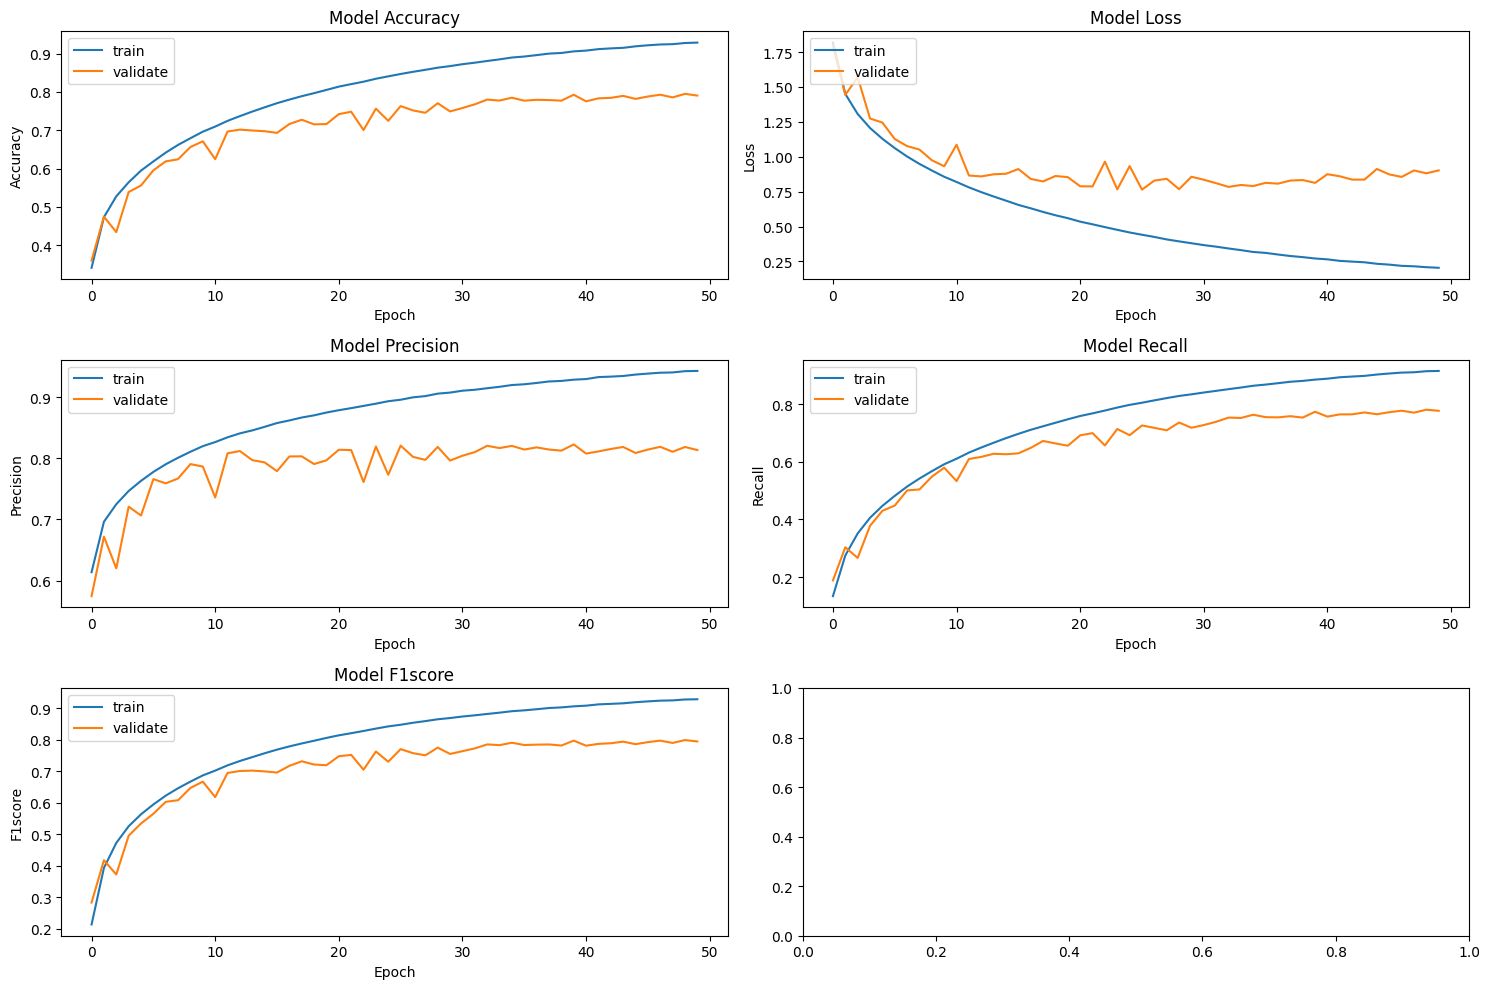

In [16]:
def plotmodelhistory(history):
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))

    # Plot accuracy
    axs[0, 0].plot(history.history['accuracy'])
    axs[0, 0].plot(history.history['val_accuracy'])
    axs[0, 0].set_title('Model Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['train', 'validate'], loc='upper left')

    # Plot loss
    axs[0, 1].plot(history.history['loss'])
    axs[0, 1].plot(history.history['val_loss'])
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['train', 'validate'], loc='upper left')

    # Plot precision_m
    axs[1, 0].plot(history.history['precision_m'])
    axs[1, 0].plot(history.history['val_precision_m'])
    axs[1, 0].set_title('Model Precision')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend(['train', 'validate'], loc='upper left')

    # Plot recall_m
    axs[1, 1].plot(history.history['recall_m'])
    axs[1, 1].plot(history.history['val_recall_m'])
    axs[1, 1].set_title('Model Recall')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend(['train', 'validate'], loc='upper left')

    # Plot f1score_m
    axs[2, 0].plot(history.history['f1_m'])
    axs[2, 0].plot(history.history['val_f1_m'])
    axs[2, 0].set_title('Model F1score')
    axs[2, 0].set_ylabel('F1score')
    axs[2, 0].set_xlabel('Epoch')
    axs[2, 0].legend(['train', 'validate'], loc='upper left')

    plt.tight_layout()
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [23]:
lost_test, accuracy_test, f1score_test, precision_test, recall_test = model.evaluate(X_test, Y_test, verbose=0)
print("Loss of test set is: ",lost_test)
print("Accuracy of test set is: ",accuracy_test)
print("F1score of test set is: ",f1score_test)
print("Precision of test set is: ",precision_test)
print("Recall of test set is: ",recall_test)

Loss of test set is:  4.740245342254639
Accuracy of test set is:  0.36080026626586914
F1score of test set is:  0.35656219720840454
Precision of test set is:  0.3672908842563629
Recall of test set is:  0.34738245606422424


### Draw confusion matrix

In [19]:
labels = list(label)
labels

['right little',
 'right middle',
 'right ring',
 'right thumb',
 'right index',
 'left little',
 'left middle',
 'left ring',
 'left thumb',
 'left index']

9244/9244 [==============================] - 47s 5ms/step


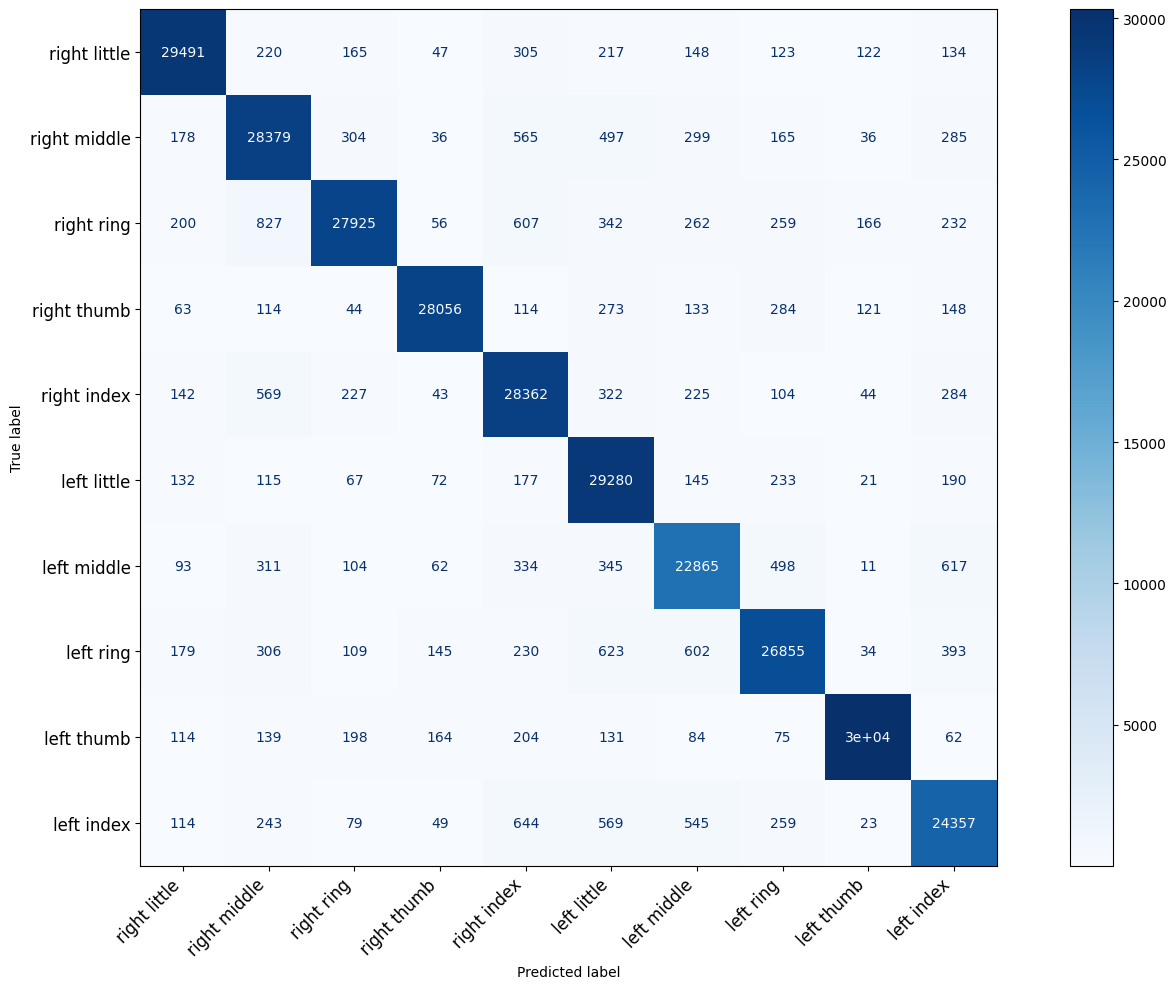

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_train, axis=1)

labels = list(label)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()


In [21]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((295791, 32, 32, 1), (295791, 10), (85970, 32, 32, 1), (85970, 10))

2687/2687 [==============================] - 13s 5ms/step


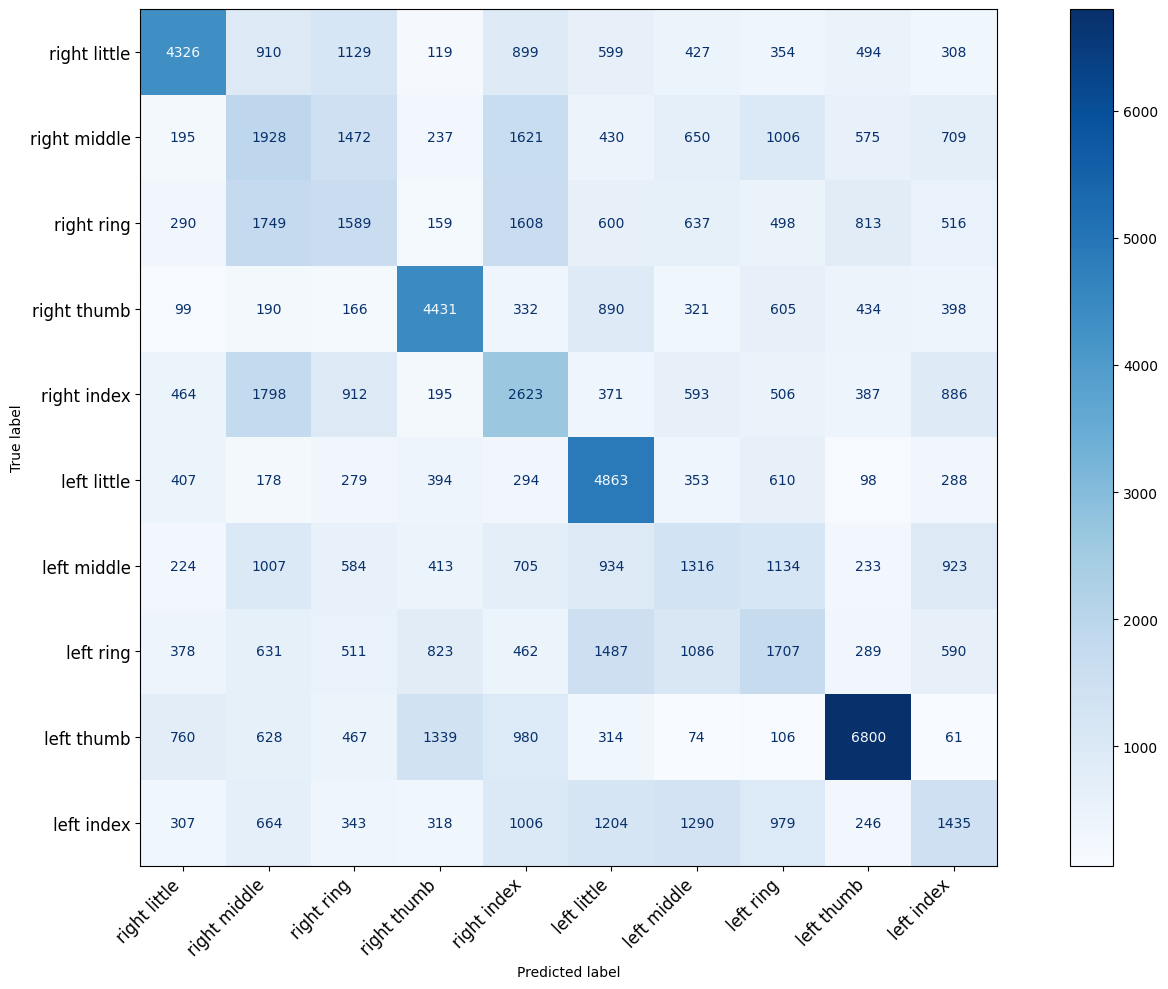

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

labels = list(label)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()
